In [1]:
##############################Kalman Filter operation#####################################
import numpy as np
import pybamm
import os
import pandas as pd
import simpy
import matplotlib.pyplot as plt
from typing import List, Dict, Union
from battery_data_analysis import BatteryPolynomialFit

# os.chdir(pybamm.__path__[0]+'/..')

pybamm.set_logging_level('NOTICE')

In [2]:
# Used to get the state of charge (SoC) from an open circuit voltage (OCV) reading,
# using a SoC(OCV) function calculated with an 8th order polynomial fit of the cell's quasi-OCV discharge at ~1/20C
# Inputs: the measured cell OCV from Arduino, coefficients form poly fit, OCV min and OCV max
# Returns: the state of charge SoC
def getSoCFromOCV(OCV, coefficients, OCV_min, OCV_max):
    OCV_used = OCV
    # ensures that only OCVs within the bounds of the polynomial fit are used
    if OCV_used < OCV_min:
        OCV_used = OCV_min
    if OCV_used > OCV_max:
        OCV_used = OCV_max
    # calculates the state of charge from the OCV
    SoC = 0
    i = 0
    coefficients_len = len(coefficients)
    while coefficients_len - i > 0:
        SoC += coefficients[i] * OCV_used ** (coefficients_len - i)
        i += 1
    # returns the state of charge as a function of measured open circuit voltage (OCV)
    return SoC

# Initializes the state matrix for the Kalman Filter
# Inputs: the initial measured state of charge SoC and current I
# Returns: the state matrix to be used in the Kalman Filter
def initStateVariable(SoC, I):
    return np.array([SoC], [I])


# Updates the Kalman Filter's transformation matrix with the appropriate time interval
# Inputs: the measured time interval between operations
# Returns: the correct transformation matrix to be used in Kalman Filter operations
def updateTransformationMatrix(deltaT, totalCoulombs):
    return np.array([[1, -1 * (deltaT / totalCoulombs) * 100], [0, 1]])


In [25]:
class PybammBattery:

    def __init__(self, env, capacity, soc=0, Vmin=2.8, Vmax=4.5):
        self.env = env
        self.capacity = capacity
        self.soc = soc
        self.start_time = 0
        
        # load solver
        self.solver = pybamm.CasadiSolver()
        
        # load model
        self.model = pybamm.lithium_ion.SPMe()
        
        # load parameter values and process model and geometry
        self.parameter_values = pybamm.ParameterValues('Marquis2019')
        
        # Create the BatteryPolynomialFit and get coefficients list
        self.battery_polynomial_fit = BatteryPolynomialFit(self.model.new_copy(), self.parameter_values.copy())
        
        # Set the step_solution to the last solution
        self.step_solution = self.battery_polynomial_fit.last_solution
        
        # Set initial voltage and initial SOC
        self.Vmax = self.battery_polynomial_fit.Vmax
        self.Vmin = self.battery_polynomial_fit.Vmin
        self.coefficients_list = self.battery_polynomial_fit.coefficients_list
        self.initial_voltage = self.step_solution['Terminal voltage [V]'].entries[-1]
        self.initial_SOC = getSoCFromOCV(self.initial_voltage, self.coefficients_list, self.Vmin, self.Vmax)
        self.initial_current = self.parameter_values['Current function [A]']
        
        geometry = self.model.default_geometry
        self.parameter_values['Current function [A]'] = "[input]"
        self.parameter_values.process_model(self.model)
        self.parameter_values.process_geometry(geometry)
        
        # set mesh
        mesh = pybamm.Mesh(geometry, self.model.default_submesh_types, self.model.default_var_pts)

        # discretise model
        disc = pybamm.Discretisation(mesh, self.model.default_spatial_methods)
        disc.process_model(self.model)
        
        # Set up states and variances
        self.last_state1 = np.array([[self.initial_SOC], [self.initial_current]])
        self.last_state2 = np.array([[self.initial_SOC], [self.initial_current]])
        
        self.last_variance1 = np.array([[.5, 0], [0, .5]])
        self.last_variance2 = np.array([[.5, 0], [0, .5]])
        
        # Initialize observation matrix
        self.observation_matrix = np.array([[1, 0], [0, 1]])
        self.observation_noise2 = np.array([[.25, 0], [0, .25]])
        
        # Initialize the transofrmation matrix
        self.total_coulombs = self.parameter_values['Nominal cell capacity [A.h]'] * 60 * 60
        delta_t = 0
        self.transformation_matrix = np.array([[1, -1 * (delta_t / self.total_coulombs) * 100], [0, 1]])
            
        
    def update(self, current):
        if current == 0:
            return 0
        
        if self.step_solution is not None:
            print('condition final time: ', not (
            self.step_solution.termination == "final time"
            or "[experiment]" in self.step_solution.termination
        ))
        
        dt = 60
        self.start_time += dt
        input_parameters= {}
        input_parameters['Current function [A]'] = current
        self.step_solution = self.solver.step(self.step_solution, self.model, dt=dt, npts=100, inputs=input_parameters)
        
        self.transformation_matrix = updateTransformationMatrix(dt, self.total_coulombs)
        
        # Estimate the state
        state_estimate1 = np.matmul(self.transformation_matrix, self.last_state1)
        state_estimate2 = np.matmul(self.transformation_matrix, self.last_state2)
        
        variance_estimate1 = np.matmul(
            np.matmul(self.transformation_matrix, self.last_variance1), 
            np.linalg.inv(self.transformation_matrix)
        )
        variance_estimate2 = np.matmul(
            np.matmul(self.transformation_matrix, self.last_variance2), 
            np.linalg.inv(self.transformation_matrix)
        )
        
        state_current = current
        
        # Update the current stored in the last state
        state_estimate1[1] = state_current
        state_estimate2[1] = state_current
        
        # Update the last state to current state estimate
        self.last_state1 = state_estimate1
        self.last_state2 = state_estimate2
        
        # Update the last variance to current variance estimate
        self.last_variance1 = variance_estimate1
        self.last_variance2 = variance_estimate2
        
        if (self.start_time % 600) == 0:
            measured_voltage = self.step_solution['Measured open circuit voltage [V]'].entries[-1]
            
            # Calculate the measured SOC from OCV
            measured_soc = getSoCFromOCV(measured_voltage, self.coefficients_list, self.Vmin, self.Vmax)
            
            # Use the measured current from most recent estimated state update
            measured_current = state_current
            
            # Create the state measurement matrix
            state_measurement = np.array([[measured_soc], [measured_current]])
            
            # CALCULATE
            # ---------

            # Calculate the measurement residual vector
            measurement_residual2 = state_measurement - state_estimate2
            
            # Calculate the residual variance matrix
            residual_variance2 = variance_estimate2  + self.observation_noise2
            
            # Calculate the Kalman gain
            kalman_gain2 = np.matmul(variance_estimate2, np.linalg.inv(residual_variance2))
            
            # UPDATE
            # ------

            # Update the state
            self.last_state2 = state_estimate2 + np.matmul(kalman_gain2, measurement_residual2)
            
            # Update the variance
            self.last_variance2 = np.matmul((np.identity(2) - kalman_gain2), variance_estimate2)
        
        return (self.last_state1[0], self.last_state2[0])

In [26]:
def simulate(battery: PybammBattery, current_delta_list: List[float], records: List[Dict]):
    
    for current_delta in current_delta_list:
        coulomb, kalman = battery.update(current_delta)
        records.append({
            "current_delta": current_delta,
            "soc_coulomb": coulomb,
            "soc_kalman": kalman
        })

In [27]:
# import drive cycle from file
drive_cycle = pd.read_csv(f"{pybamm.__path__[0]}/input/drive_cycles/US06.csv", comment="#", header=None).to_numpy()

# For now let's assume the simple case of one step every second where we first (dis)charge and then implicitly read.
# Later we can extend this to a more asynchronous charge/discharge/read pattern with different processes if we want
# current_delta_list = [-0.52, 0.069, 1, -1, -0.65, 1]
current_delta_list = drive_cycle[:, 1]
records = []  # log of some infos for later analysis

battery = PybammBattery(None, capacity=5)
simulate(battery, current_delta_list, records)

result = pd.DataFrame(records)
with open("result.csv", "w") as f:
    f.write(result.to_csv())
print(result)

2022-05-25 13:24:41,711 - [NOTICE] simulation.solve(755): Cycle 1/1 (16.310 ms elapsed) --------------------
2022-05-25 13:24:41,712 - [NOTICE] simulation.solve(789): Cycle 1/1, step 1/5: Discharge at C/20 until 3.105 V
2022-05-25 13:24:41,970 - [NOTICE] simulation.solve(789): Cycle 1/1, step 2/5: Rest for 4 hours
2022-05-25 13:24:42,046 - [NOTICE] simulation.solve(789): Cycle 1/1, step 3/5: Charge at 0.2 C until 4.1 V
2022-05-25 13:24:42,167 - [NOTICE] simulation.solve(789): Cycle 1/1, step 4/5: Discharge at C/20 until 3.105 V
2022-05-25 13:24:42,448 - [NOTICE] simulation.solve(789): Cycle 1/1, step 5/5: Charge at 0.2 C until 3.6025 V
2022-05-25 13:24:42,655 - [NOTICE] simulation.solve(911): Finish experiment simulation, took 959.947 ms



FITTING RESULTS
---------------
Optimal Order Fit: 8
Chi-Squared Value: 2245.059248340768
Coefficients:
	x^8: -378633.0976387885
	x^7: 10926487.030202843
	x^6: -137760694.31313083
	x^5: 991136847.1489915
	x^4: -4450624769.415335
	x^3: 12772780234.40649
	x^2: -22878405184.665363
	x^1: 23384234104.46959
	x^0: -10442239787.387098
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
condition final time:  False
con

     current_delta            soc_coulomb             soc_kalman
0         0.012859  [-15.939852396647135]  [-15.939852396647135]
1         0.012859  [-15.971341028513953]  [-15.971341028513953]
2         0.012859  [-16.002829660380772]  [-16.002829660380772]
3         0.012859   [-16.03431829224759]   [-16.03431829224759]
4         0.012859   [-16.06580692411441]   [-16.06580692411441]
..             ...                    ...                    ...
596       0.012859  [-1252.7230490400798]   [-595.6118907148434]
597       0.012859  [-1252.7545376719465]   [-595.6433793467103]
598       0.012859  [-1252.7860263038133]   [-595.6748679785771]
599       0.012859    [-1252.81751493568]   [-587.1369318852479]
600       0.012859  [-1252.8490035675468]   [-587.1684205171148]

[601 rows x 3 columns]


<AxesSubplot:>

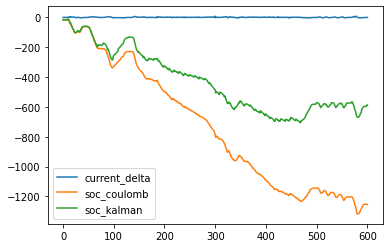

In [28]:
result['current_delta'] = result['current_delta'].astype(float)
result['soc_coulomb'] = result['soc_coulomb'].astype(float)
result['soc_kalman'] = result['soc_kalman'].astype(float)

# fig, ax1 = plt.subplots()
# ax1.set_ylabel("Current [A]")
# result.plot(x='time', y='solar', figsize=(15,4), color="#ff9869", ax=ax1)

# # Plot taxis
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel("Taxis per 15min")
# taxi_count_slice = taxi_count_15min["2021-06-01 00:00:00":"2021-06-05 00:00:00"]
# taxi_count_slice = taxi_count_slice.reset_index()
# taxi_count_slice.plot(x='pickup_datetime', y='taxi_count', figsize=(15,4), color="black", ax=ax2)
result.plot()

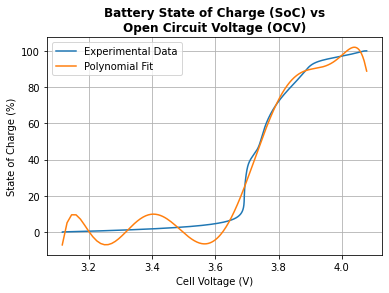

In [29]:
polynomial = battery.battery_polynomial_fit
plt.plot(polynomial.voltage_reading_final, polynomial.normalized_SoC, label='Experimental Data')
# Plots the modeled values using the polynomial fit for SoC vs OCV
plt.plot(polynomial.voltage_reading_final, polynomial.modeled_values, label='Polynomial Fit')
plt.legend(loc='best')
plt.ylabel('State of Charge (%)')
plt.xlabel('Cell Voltage (V)')
plt.title("Battery State of Charge (SoC) vs\nOpen Circuit Voltage (OCV)", fontweight='bold')
plt.grid(True)
plt.savefig('polynomialfit_Marquis2019_SPMe.png', bbox_inches='tight')

In [24]:
sorted(battery.model.variables)

['Ambient temperature',
 'Ambient temperature [K]',
 'Average negative particle concentration',
 'Average negative particle concentration [mol.m-3]',
 'Average positive particle concentration',
 'Average positive particle concentration [mol.m-3]',
 'Battery voltage [V]',
 'C-rate',
 'Cell temperature',
 'Cell temperature [K]',
 'Change in measured open circuit voltage',
 'Change in measured open circuit voltage [V]',
 'Current [A]',
 'Current collector current density',
 'Current collector current density [A.m-2]',
 'Current density variable',
 'Discharge capacity [A.h]',
 'Electrode current density',
 'Electrode transport efficiency',
 'Electrolyte concentration',
 'Electrolyte concentration [Molar]',
 'Electrolyte concentration [mol.m-3]',
 'Electrolyte current density',
 'Electrolyte current density [A.m-2]',
 'Electrolyte flux',
 'Electrolyte flux [mol.m-2.s-1]',
 'Electrolyte potential',
 'Electrolyte potential [V]',
 'Electrolyte transport efficiency',
 'Exchange current density'